# Notes for ME 622 Grader
This code is a work in progress and is the current state of how things are as of 11 April 2025. There are some things that are not working 100% like the way I want to. I identified these things in my progress report and am working on them. This is just the latest version of the code that does not have any of the work in progress features because those features don't work yet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [3]:
# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)
a = 0 # Constant force of 0 N

# Control Parameters
k_x = 0 # currently no control
k_xdot = 0

F0 = m*a

# Noise for measurements: (standard deviations)
v = [0.05, 0.05, 0.05, 0.05] # Position, velocity noise

# Desired trajectory

In [4]:
def desired_trajectory(t):
    x_desired = 0*np.ones_like(t)
    return x_desired

# Nonlinear continuous time dynamics with control

In [5]:
def control(X, t):
    x, xdot= np.ravel(X)
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [6]:
def f(X, t):
    x, xdot = X
    
    # control
    F = control(X, t)
    
    # dynamics
    d_x = xdot
    d_xdot = (-k*x)/m -c*xdot/m + F0/m
    
    d_x = [d_x, d_xdot]
    
    return d_x

# Run simulation

In [7]:
t = np.arange(0, 10, 0.01) # Time

x0 = np.array([1.0, 0.0])  # Initial displacement and velocity

result = odeint(f, x0, t)
X = result.T

# Plot results

Plot the simulation results. These are the true states of the system. Here, we will be plotting the results for the ***incorrect C***, which has one row different than the correct C.
$$\begin{matrix}
\text{incorrect C as measurements:}&
C =\begin{bmatrix}
1&0\\
0&1\\
10&0\\
1&1
\end{bmatrix}\\
\text{correct C given to kalman filter later:}&
C=\begin{bmatrix}
1&0\\
0&1\\
2&0\\
1&1
\end{bmatrix}
\end{matrix}$$

In [8]:
x = X[0, :]
xdot = X[1, :]

tenx = 10*x
xxdot = x + xdot

# append tenx and xxdot to X
X = np.vstack((X, tenx))
X = np.vstack((X, xxdot))

tenx = X[2, :]
xxdot = X[3, :]

x_des = desired_trajectory(t)

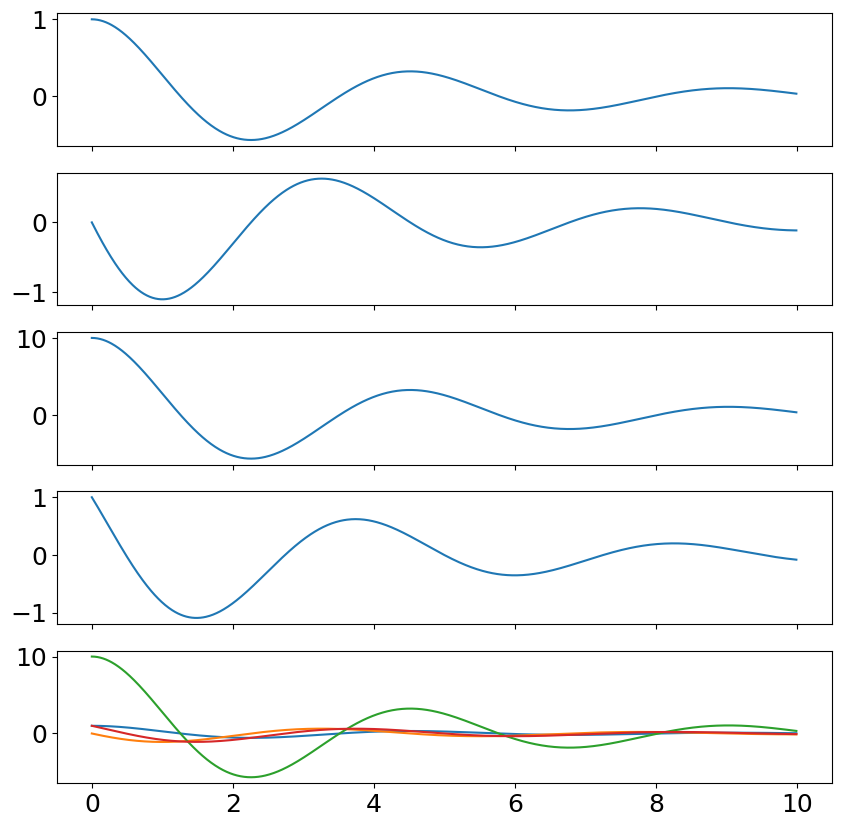

In [9]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
ax[1].plot(t, xdot, label='xdot')
ax[2].plot(t, tenx, label='10*x')
ax[3].plot(t, xxdot, label='x+xdot')

# plot everything on tyhe last axis
ax[4].plot(t, x, label='x')
ax[4].plot(t, xdot, label='xdot')
ax[4].plot(t, tenx, label='10*x')
ax[4].plot(t, xxdot, label='x+xdot')

# Measurements

Now, we will generate noisy measurements. 

In [10]:
def h(x, v):
    x, xdot, tenx, xxdot = x
    
    y = np.array([x, xdot, tenx, xxdot])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [11]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T
print(np.shape(Y))

(4, 1000)


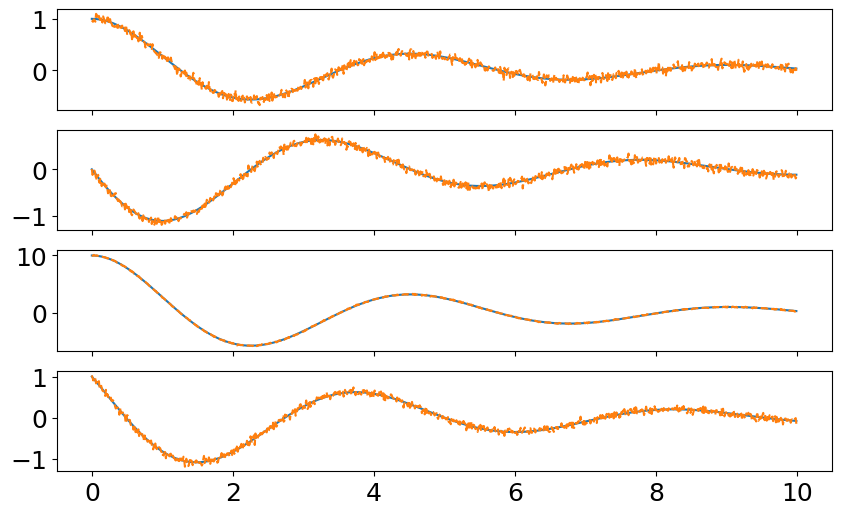

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
ax[0].plot(t, Y[0, :], label='x_m', linestyle='--')
ax[1].plot(t, xdot, label='xdot')
ax[1].plot(t, Y[1, :], label='xdot_m', linestyle='--')
ax[2].plot(t, tenx, label='10*x')
ax[2].plot(t, Y[2, :], label='10*x_m', linestyle='--')
ax[3].plot(t, xxdot, label='x+xdot')
ax[3].plot(t, Y[3, :], label='x+xdot_m', linestyle='--')

# Discrete Linearized
This is where we define the correct C matrix for the kalman filter. We also need to get every unique combination of rows of C.
$$
C = \begin{bmatrix}
1 & 0\\
0 & 1\\
2 & 0\\
1 & 1
\end{bmatrix}
$$

In [13]:
def control_linear(X, t):
    x, xdot, tenx, xxdot = X
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [14]:
# Here, we will define the dyanmics of the system
import itertools
dt = np.mean(np.diff(t))

A = np.array([[0, 1],
              [-k/m, -c/m]])

B = np.array([[0],
              [1/m]])

C_original = np.array([[1, 0],
                       [0, 1],
                       [2, 0],
                       [1, 1]])
# Get all the unique combinations of rows in C
print('C matrices:')
C = []
num_rows = len(C_original)
for r in range(1, num_rows + 1):  # r determines subset size
    for combo in itertools.combinations(C_original, r):
        #print(np.array(combo))  # Each combo is a tuple of rows
        #print()
        C.append(combo)

C matrices:


# Organize some inputs for the KF

In [15]:
def get_params(Cmat):
    # get the control inputs -- these should be known
    u = control_linear(X, t)
    u = np.vstack(u).T

    # R is determined by the variance, thus the square of the standard deviation
    v = 0.05*np.eye(np.shape(Cmat)[0])
    R = v**2 # make sure R matches the dimensions of C!!!!! and Y
    R = np.atleast_2d(R)
    # Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
    # But they can be led astray, and are slower to converge 
    Q = 0.025*np.eye(np.shape(A)[0])  # Make sure this changes with the dimensions of A and B!!!

    # initial state estimate
    x0 = np.array([1.5, 0.5])  # Initial displacement and velocity
    x0 = np.atleast_2d(x0).T

    # initial covariance estimate
    P0 = 0.1*np.eye(np.shape(A)[0]) # Make sure this changes with the dimensions of A and Y!!!
    return x0, P0, u, R, Q

# Run the KF

In [16]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [17]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [18]:
import pandas as pd
# create a list of dataframes. The number of dataframes is the length of C. 
results = [pd.DataFrame(columns=['x', 'xdot', 'P', 'Pdot', 'P0', 'Q', 'R', 'Jk', 'invJk']) for i in range(len(C))]
#all_R = []
for i in range(len(C)):
    thisC = np.array(C[i])
    x0, P0, u, R, Q = get_params(thisC)
    #all_R.append(R)

    #thisY = thisC @ Y
    # compare thisC with C_original and find what rows are in thisC
    # then use those rows to index the Y matrix
    thisY = np.zeros((np.shape(thisC)[0], np.shape(Y)[1]))
    for j in range(np.shape(thisC)[0]):
        thisY[j, :] = Y[np.where(np.all(C_original == thisC[j], axis=1))[0][0], :]
    #print(thisC)
    #print(np.shape(thisY))
    #print()

    xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, thisY, u, A, B, thisC, R, Q) # NEED TO ADJUST Y TO MATCH C
    results[i]['x'] = xhat_fp[0, :]
    results[i]['xdot'] = xhat_fp[1, :]
    P = np.array(P_fp)
    results[i]['P'] = P[:, 0, 0]
    results[i]['Pdot'] = P[:, 1, 1]
    results[i].at[0,'P0'] = P0
    results[i].at[0,'Q'] = Q
    results[i].at[0,'R'] = R

# make the length of all dataframes 1000
for i in range(len(C)):
    results[i] = results[i].iloc[:1000]
    

# Plot KF Results
Plot all of the data from the Kalman filter for every C

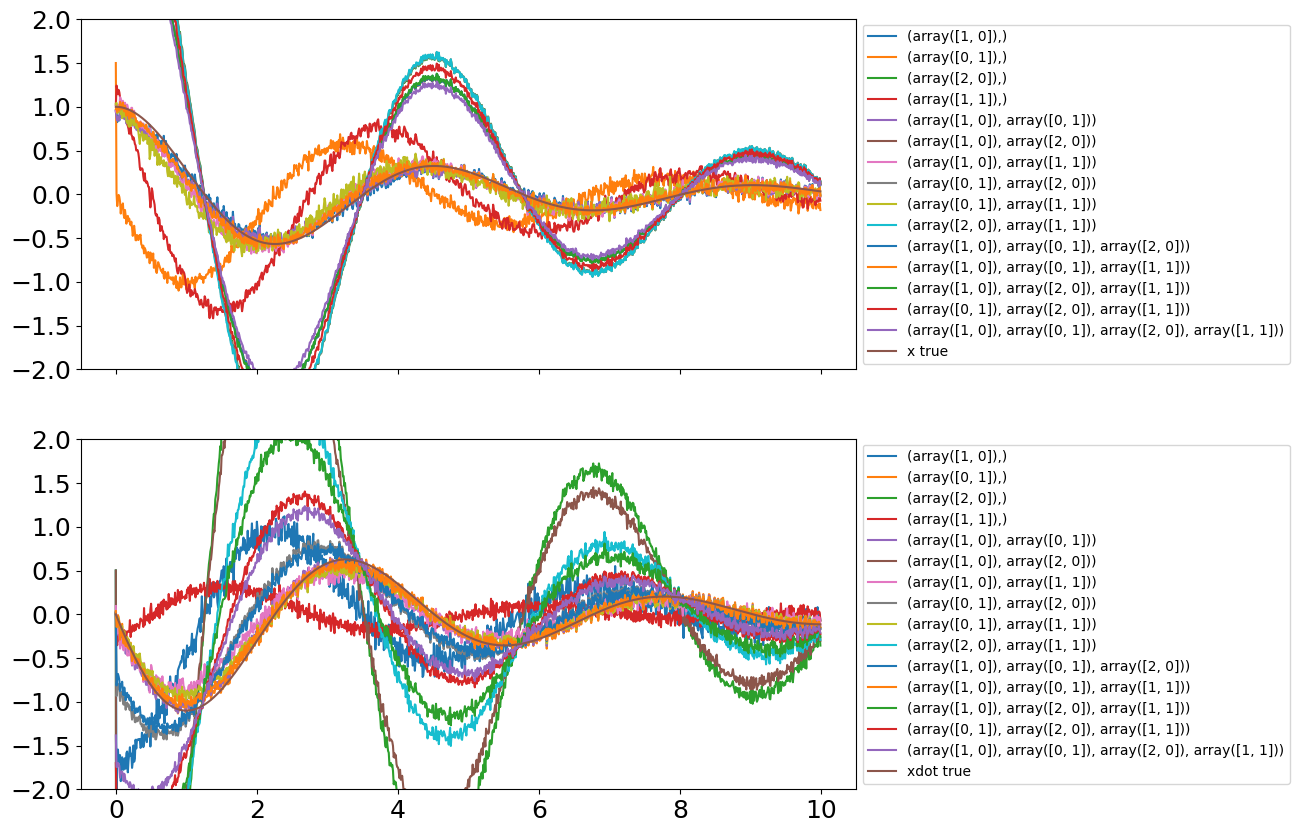

In [19]:
# plot x and xdot for all data sets in results
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# set the font size
plt.rcParams.update({'font.size': 10})
for i in range(len(C)):
    ax[0].plot(t, results[i]['x'], label=C[i])
    ax[1].plot(t, results[i]['xdot'], label=C[i])
ax[0].plot(t, x, label='x true')
ax[1].plot(t, xdot, label='xdot true')

# set y limits
ax[0].set_ylim(-2, 2)
ax[1].set_ylim(-2, 2)

# put a legend to the right side
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Analyze the error

Do everything for both position (x) and velocity (xdot)

In [20]:
# compute Jk for every C matrix
inv = np.linalg.inv
for i in range(len(C)):
    thisC = np.array(C[i])
    Q = np.atleast_2d(np.array(results[i].loc[0, 'Q']))
    R = np.atleast_2d(np.array(results[i].loc[0, 'R']))
    P0 = np.atleast_2d(np.array(results[i].loc[0, 'P0']))
    A = np.atleast_2d(A)

    Jk = inv(Q) - inv(Q) @ A @ inv(P0 + A.T @ inv(Q) @ A) @ A.T @ inv(Q) + thisC.T @ inv(R) @ thisC
    results[i].at[0, 'Jk'] = Jk

    # compute the inverse of Jk
    lamb = 1e-5
    Jk = Jk + lamb*np.eye(np.shape(Jk)[0])
    invJk = inv(Jk)
    results[i].at[0, 'invJk'] = invJk
    print(C[i])
    # print('invJk:', invJk)
    # print()


(array([1, 0]),)
(array([0, 1]),)
(array([2, 0]),)
(array([1, 1]),)
(array([1, 0]), array([0, 1]))
(array([1, 0]), array([2, 0]))
(array([1, 0]), array([1, 1]))
(array([0, 1]), array([2, 0]))
(array([0, 1]), array([1, 1]))
(array([2, 0]), array([1, 1]))
(array([1, 0]), array([0, 1]), array([2, 0]))
(array([1, 0]), array([0, 1]), array([1, 1]))
(array([1, 0]), array([2, 0]), array([1, 1]))
(array([0, 1]), array([2, 0]), array([1, 1]))
(array([1, 0]), array([0, 1]), array([2, 0]), array([1, 1]))


# Plotting with Error

Now, I will plot my state estimates with a 3 sigma region

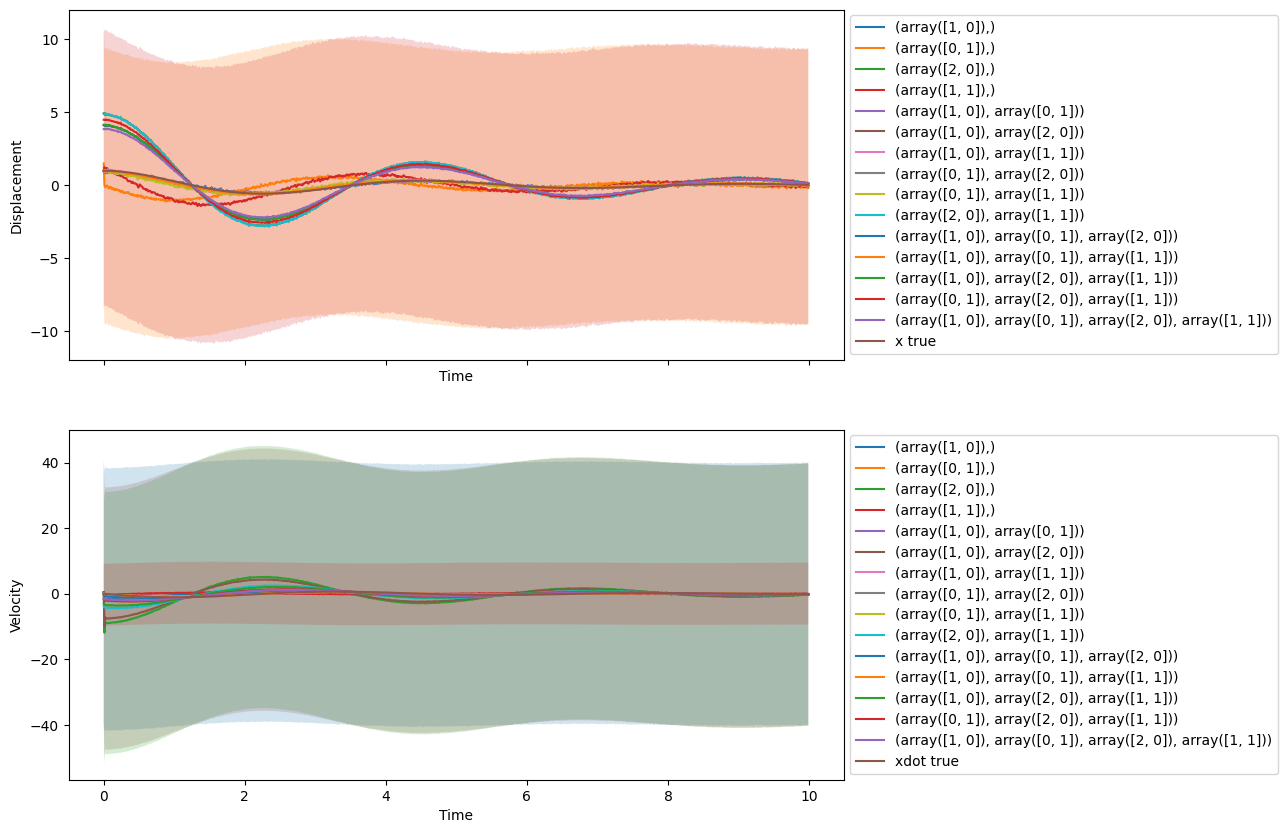

In [21]:
# Plot the state estimates of x and xdot with their invJk bounds

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plt.rcParams.update({'font.size': 10})

for i in range(len(C)):
    x_hat = results[i]['x']
    xdot_hat = results[i]['xdot']
    invJk_x = results[i].loc[0, 'invJk'][0, 0]
    invJk_xdot = results[i].loc[0, 'invJk'][1, 1]
    ax[0].plot(t, x_hat, label=C[i])
    ax[0].fill_between(t, x_hat-invJk_x, x_hat+invJk_x, alpha=0.2)
    ax[1].plot(t, xdot_hat, label=C[i])
    ax[1].fill_between(t, xdot_hat-invJk_xdot, xdot_hat+invJk_xdot, alpha=0.2)
ax[0].plot(t, x, label='x true')
ax[1].plot(t, xdot, label='xdot true')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Displacement')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
# ax[0].set_ylim(-2, 2)
# ax[1].set_ylim(-2, 2)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Sorting Out Based on Large Error

Now, I will try and disregard a sensor if the error in the sensor is large. 

In [22]:
# for every position and velocity, if invJk is bigger than 1, then we want to disregard the data
# we will use invJk to determine if the data is trustworthy or not
trustworthy_x = []
trustworthy_xdot = []

for i in range(len(C)):
    invJk_x = results[i].loc[0, 'invJk'][0, 0]
    if invJk_x < 1:
        trustworthy_x.append(i)
    else:
        continue
for j in range(len(C)):
    invJk_xdot = results[j].loc[0, 'invJk'][1, 1]
    if invJk_xdot < 1:
        trustworthy_xdot.append(j)
    else:
        continue

print(trustworthy_x)
print()
print(trustworthy_xdot)

[0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]


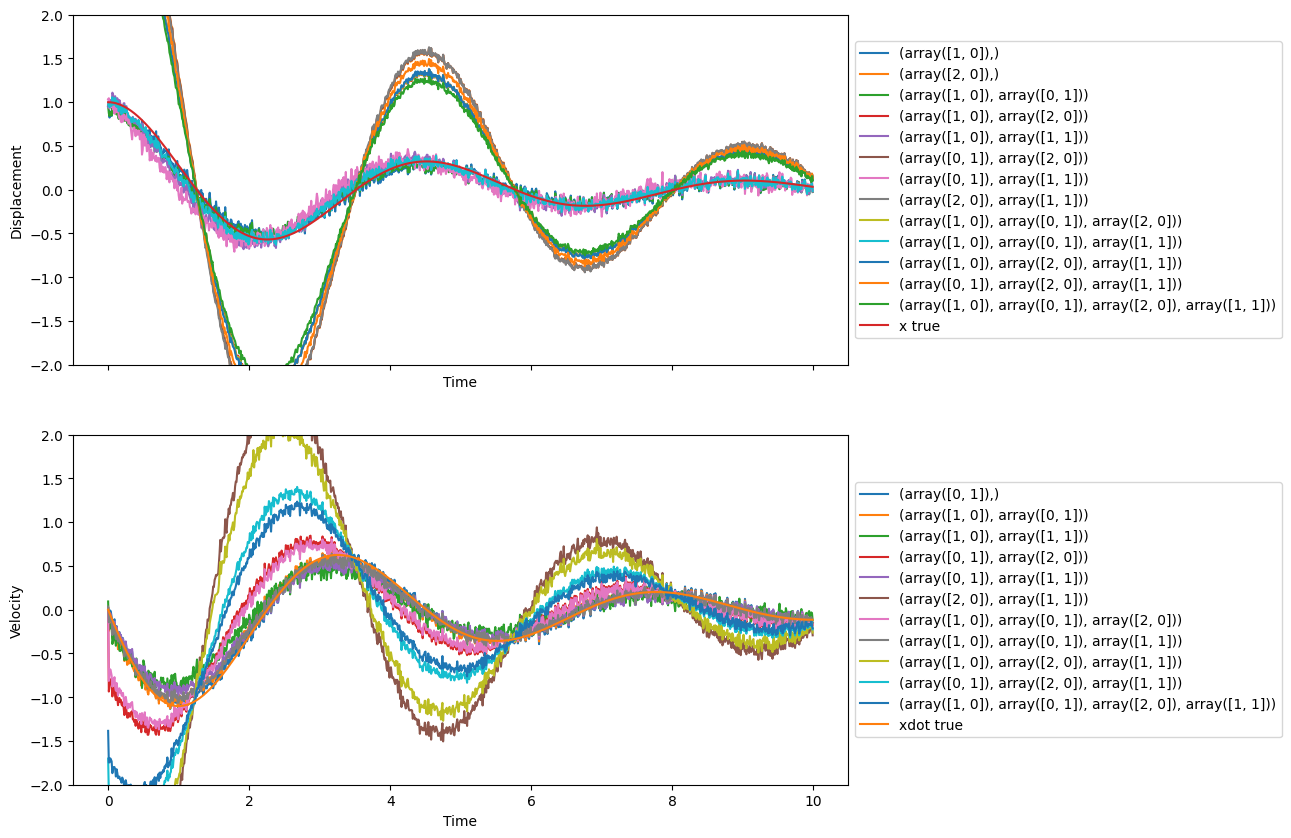

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plt.rcParams.update({'font.size': 10})
for i in range(len(trustworthy_x)):
    j = trustworthy_x[i]
    x_hat = results[j]['x']
    invJk_x = results[j].loc[0, 'invJk'][0, 0]
    ax[0].plot(t, x_hat, label=C[j])
    ax[0].fill_between(t, x_hat-invJk_x, x_hat+invJk_x, alpha=0.2)

ax[0].plot(t, x, label='x true')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Displacement')
ax[0].set_ylim(-2, 2)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in range(len(trustworthy_xdot)):
    j = trustworthy_xdot[i]
    xdot_hat = results[j]['xdot']
    invJk_xdot = results[j].loc[0, 'invJk'][1, 1]
    ax[1].plot(t, xdot_hat, label=C[j])
    ax[1].fill_between(t, xdot_hat-invJk_x, xdot_hat+invJk_x, alpha=0.2)

ax[1].plot(t, xdot, label='xdot true')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].set_ylim(-2, 2)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Agreement Heatmap
Now, put all the 'trustworthy' measurements into a heatmap to see how well they agree with one another. 

[12, 10, 5, 13, 2, 7, 9, 14, 11, 6, 4, 0, 8]


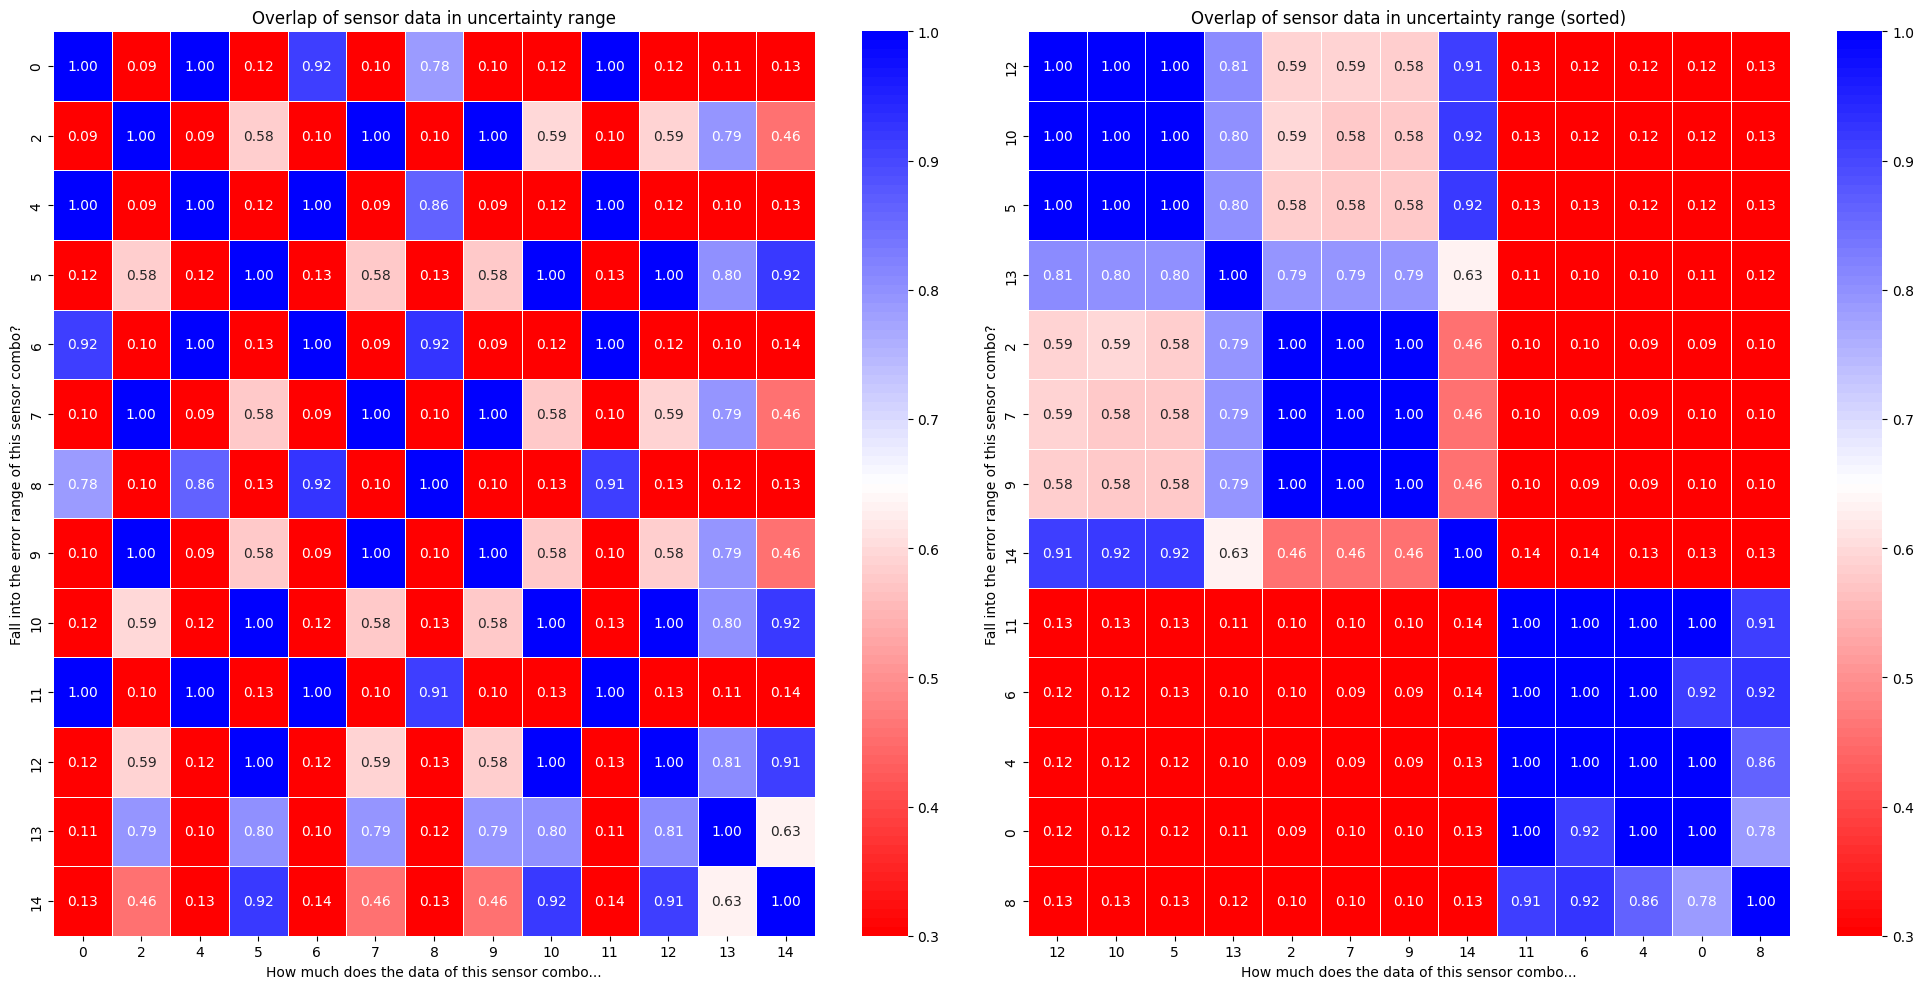

In [24]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

overlaps_x = np.ones((len(trustworthy_x), len(trustworthy_x)))
# I need to compute the percent of the time that the data from one C falls within the error range of all other C
for i in range(len(trustworthy_x)):
    for j in range(len(trustworthy_x)):
        if i == j:
            continue
        else:
            # get the index of the C matrix
            C_i = trustworthy_x[i]
            C_j = trustworthy_x[j]
            # get the data for the C matrix
            x_i = results[C_i]['x']
            x_j = results[C_j]['x']
            # get the acceptable error for the C matrix
            sigma_i = 0.15 #
            sigma_j = 0.15 #
            # get the time that the data falls within the error range
            overlap = np.sum(np.logical_and(x_i - sigma_i < x_j, x_j < x_i + sigma_i)) / len(x_i)
            overlaps_x[i, j] = overlap
# Sort the matrix now!
# Sort the adjacency matrix based on the sum of rows
row_sums = overlaps_x.sum(axis=1)
sorted_indices = np.argsort(row_sums)[::-1]  # Sort in descending order
# Reorder the matrix
sorted_overlaps_x = overlaps_x[sorted_indices, :][:, sorted_indices]
# Also sort the trustworthy_x list in the same way as the matrix
sorted_trustworthy_x = [trustworthy_x[i] for i in sorted_indices]
print(sorted_trustworthy_x)

# plot overlapvals onto a red and blue heatmap with values from 0 to 1
# Define custom colormap
colors = ["red", "white", "blue"]  # Define the colors for your gradient
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# plot the unsorted and then the sorted matrix on the same figure
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Plot the original matrix
sns.heatmap(overlaps_x, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1, ax=ax[0])
ax[0].set_title("Overlap of sensor data in uncertainty range")
ax[0].set_xlabel("How much does the data of this sensor combo...")
ax[0].set_ylabel("Fall into the error range of this sensor combo?")
ax[0].set_xticklabels(trustworthy_x)
ax[0].set_yticklabels(trustworthy_x)
# Plot the sorted matrix with the sorted indices
sns.heatmap(sorted_overlaps_x, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1, ax=ax[1])
ax[1].set_title("Overlap of sensor data in uncertainty range (sorted)")
ax[1].set_xlabel("How much does the data of this sensor combo...")
ax[1].set_ylabel("Fall into the error range of this sensor combo?")
# Set the tick labels for the sorted matrix
ax[1].set_yticklabels(sorted_trustworthy_x)
ax[1].set_xticklabels(sorted_trustworthy_x)
# Show the plot
plt.tight_layout()
plt.show()


[4, 11, 8, 1, 6, 10, 7, 14, 13, 12, 9]


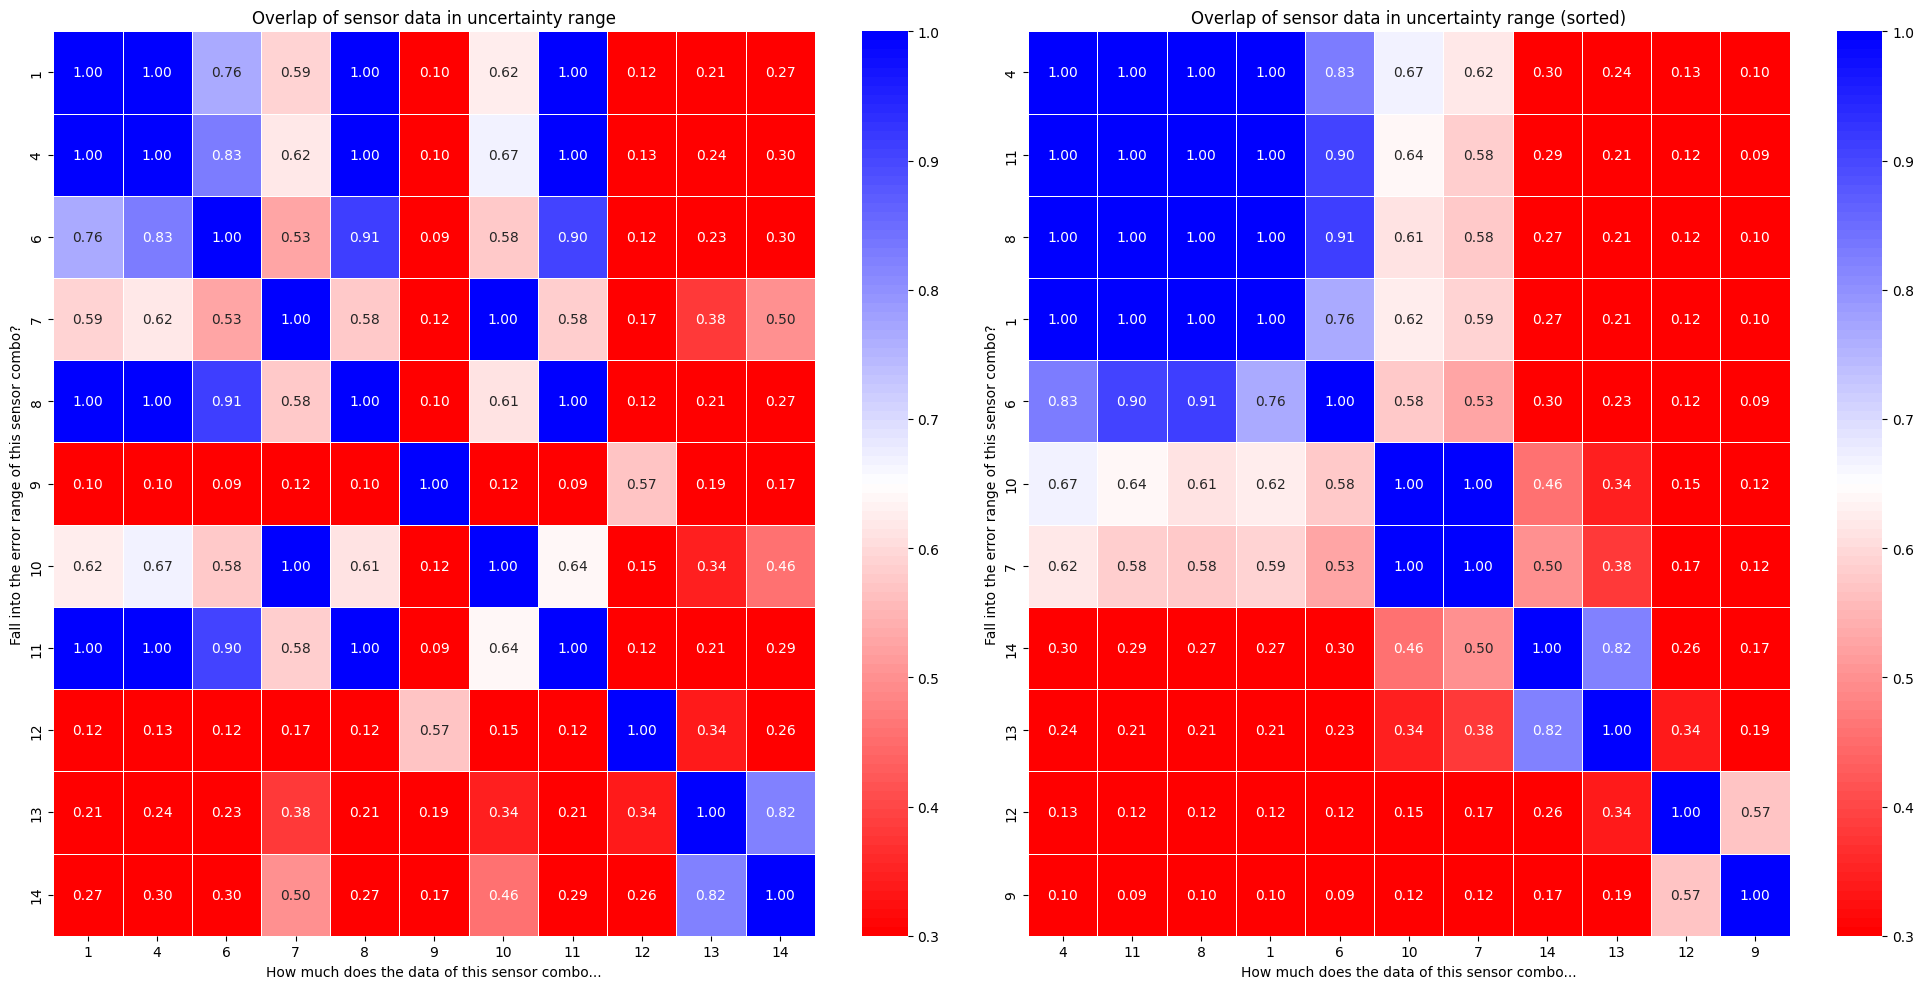

In [25]:
# Same thing as the previous cell but for xdot
overlaps_xdot = np.ones((len(trustworthy_xdot), len(trustworthy_xdot)))
# I need to compute the percent of the time that the data from one C falls within the error range of all other C
for i in range(len(trustworthy_xdot)):
    for j in range(len(trustworthy_xdot)):
        if i == j:
            continue
        else:
            # get the index of the C matrix
            C_i = trustworthy_xdot[i]
            C_j = trustworthy_xdot[j]
            # get the data for the C matrix
            xdot_i = results[C_i]['xdot']
            xdot_j = results[C_j]['xdot']
            # get the acceptable error for the C matrix
            sigma_i = 0.15 #
            sigma_j = 0.15 #
            # get the time that the data falls within the error range
            overlap = np.sum(np.logical_and(xdot_i - sigma_i < xdot_j, xdot_j < xdot_i + sigma_i)) / len(xdot_i)
            overlaps_xdot[i, j] = overlap
# Sort the matrix now!
# Sort the adjacency matrix based on the sum of rows
row_sums = overlaps_xdot.sum(axis=1)
sorted_indices = np.argsort(row_sums)[::-1]  # Sort in descending order
# Reorder the matrix
sorted_overlaps_xdot = overlaps_xdot[sorted_indices, :][:, sorted_indices]
# Also sort the trustworthy_x list in the same way as the matrix
sorted_trustworthy_xdot = [trustworthy_xdot[i] for i in sorted_indices]
print(sorted_trustworthy_xdot)
# plot overlapvals onto a red and blue heatmap with values from 0 to 1
# Define custom colormap
colors = ["red", "white", "blue"]  # Define the colors for your gradient
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
# plot the unsorted and then the sorted matrix on the same figure
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Plot the original matrix
sns.heatmap(overlaps_xdot, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1, ax=ax[0])
ax[0].set_title("Overlap of sensor data in uncertainty range")
ax[0].set_xlabel("How much does the data of this sensor combo...")
ax[0].set_ylabel("Fall into the error range of this sensor combo?")
ax[0].set_xticklabels(trustworthy_xdot)
ax[0].set_yticklabels(trustworthy_xdot)
# Plot the sorted matrix with the sorted indices
sns.heatmap(sorted_overlaps_xdot, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0.3, vmax=1, ax=ax[1])
ax[1].set_title("Overlap of sensor data in uncertainty range (sorted)")
ax[1].set_xlabel("How much does the data of this sensor combo...")
ax[1].set_ylabel("Fall into the error range of this sensor combo?")
# Set the tick labels for the sorted matrix
ax[1].set_yticklabels(sorted_trustworthy_xdot)
ax[1].set_xticklabels(sorted_trustworthy_xdot)
# Show the plot
plt.tight_layout()
plt.show()

# Sensor Identification
Now, I will identify the sensor that is NOT in the largest agreement group.

In [65]:
import networkx as nx
# for x, identify the sensors that are in groups on the heatmap where their value is greater than 0.75
print(sorted_trustworthy_x)

adj_x = np.array(sorted_overlaps_x)
threshold = 0.75

# Step 1: Threshold matrix
binary_matrix = (adj_x > threshold).astype(int)

# Step 2: Create graph
G = nx.from_numpy_array(binary_matrix)

# Step 3: Find all cliques (fully connected subgraphs)
cliques = list(nx.find_cliques(G))

# Optional: Filter cliques with 3 or more nodes
filtered_cliques = [clique for clique in cliques if len(clique) >= 3]

for i in range(len(cliques)):
    this_clique = cliques[i]
    for j in range(len(this_clique)):
        this_clique[j] = sorted_trustworthy_x[this_clique[j]]
print(cliques)

# Print the fully connected groups
for i, clique in enumerate(filtered_cliques):
    print(f"Clique {i+1}: {sorted(clique)}")

# identify the largest clique
largest_clique = max(filtered_cliques, key=len)
print(f"Largest clique: {largest_clique}")

# compile all of the combinations that are in the largest clique into one large array
C_compiled = np.array([])
for i in range(len(largest_clique)):
    thisC = np.array(C[largest_clique[i]])
    if i == 0:
        C_compiled = thisC
    else:
        C_compiled = np.vstack((C_compiled, thisC))
# only keep the unique rows
    C_compiled = np.unique(C_compiled, axis=0)

# find all the rows of C_original that are not in C_compiled
original_rows = set(map(tuple, C_original))
compiled_rows = set(map(tuple, C_compiled))

# Get the difference
diff_rows = original_rows - compiled_rows

# Convert back to list of lists (or keep as list of tuples if you prefer)
diff_list = [list(row) for row in diff_rows]
print()
print('bad sensor:')
print(diff_list)
    


[12, 10, 5, 13, 2, 7, 9, 14, 11, 6, 4, 0, 8]
[[13, 12, 10, 5], [13, 2, 7, 9], [14, 12, 10, 5], [11, 6, 4, 0, 8]]
Clique 1: [5, 10, 12, 13]
Clique 2: [2, 7, 9, 13]
Clique 3: [5, 10, 12, 14]
Clique 4: [0, 4, 6, 8, 11]
Largest clique: [11, 6, 4, 0, 8]

bad sensor:
[[2, 0]]
